In [2]:
import numpy as np
import pandas as pd
import math

import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.colors import LinearSegmentedColormap as cmap
import pygbrowse

import scanpy as sc
import scvelo as scv
from sklearn.neighbors import NearestNeighbors
from harmony import harmonize

from scipy import stats
from tqdm.notebook import tqdm
import ipywidgets
from scipy.ndimage import gaussian_filter
from scipy.signal import gaussian, fftconvolve
from math import ceil, floor
from glob import glob

import sys
sys.path.insert(1, '/Users/prullens/Documents/GitHub/scChromTools/local/')
import scChromTools as scct
import scChromUtils as sccu 

### Functions

In [3]:
def labels_to_rgb(data, label_order, hex_colors):
    label_order = list(label_order)
    label_idx = [label_order.index(label) for label in data]
    assert len(label_order) <= len(hex_colors), 'less `hex_colors` than unique `labels`'
    rgb_colors = list()
    for hex_color in hex_colors:
        rgb_colors.append([int(hex_color.lstrip('#')[i:i+2], 16) for i in (0, 2, 4)])
    return np.array([rgb_colors[i] for i in label_idx])

In [4]:
import matplotlib.colors as mcolors
def hex_to_rgb(hex_color):
    """Convert hex to RGB."""
    return np.array(mcolors.to_rgb(hex_color))

def rgb_to_hex(rgb_color):
    """Convert RGB to hex."""
    return mcolors.to_hex(rgb_color)

def generate_color_gradient(start_hex, end_hex, n=10):
    """Generate a gradient list of hex colors from start to end."""
    start_rgb = hex_to_rgb(start_hex)
    end_rgb = hex_to_rgb(end_hex)
    
    gradient = [rgb_to_hex(start_rgb + (end_rgb - start_rgb) * i / (n - 1)) for i in range(n)]
    return gradient

### Plot settings

In [5]:
COLORS = np.array(plt.rcParams['axes.prop_cycle'].by_key()['color'])

# presentation style
plt.matplotlib.rcParams['font.weight'] = 'normal'
plt.matplotlib.rcParams['axes.titleweight'] = 'normal'
plt.matplotlib.rcParams['axes.facecolor'] = plt.matplotlib.colors.to_hex((1., 1., 1., 1.), keep_alpha=True)

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams['figure.dpi'] = 150

plt.rcParams['axes.linewidth'] = .25
plt.rcParams['xtick.major.size'] = 7
plt.rcParams['xtick.major.width'] = .25
plt.rcParams['ytick.major.size'] = 7
plt.rcParams['ytick.major.width'] = .25

import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

OUTDIR = '/Users/prullens/Documents/manuscripts/invivo/figure5_mecp2dam126/'

### Global variables

In [6]:
CHROMS = [str(i) for i in list(range(1,20)) + ["X"]]

CHROMSIZES = '/Users/prullens/metadata/mm10_chrom_sizes.tsv'
BLACKLIST = '/Users/prullens/metadata/mm10.blacklist.bed'
EXPECTED = '/Users/prullens/metadata/mm10_mappability_binsize_%i.hdf5'

chromsizes = pd.read_csv(CHROMSIZES, sep='\t', header=None).groupby(0)[1].apply(int).to_dict()

DAMIDFN_BASE = '/Users/prullens/Documents/projects/invivo/experiments/{}/hdf5/{}.index{:02d}.DamID2_BC_{:03d}.top_n_2.event_counts.binsize_{}.hdf5'

### Data 

In [7]:
gtf = pd.read_csv('/Users/prullens/metadata/mm10.Mus_musculus.GRCm38.89.with_ERCC.gff.tsv.gz', sep='\t', index_col='gene_id')
gtf['gene_length'] = np.diff(gtf[['Start','End']], axis=1)

_pygBrowse_

In [8]:
genemodels = pygbrowse.datasources.Gff3Annotations('/Users/prullens/metadata/Mus_musculus.GRCm38.93.chr.gff3.bgzf', 
                                                   component_types=('CDS','three_prime_UTR', 'five_prime_UTR')
)
genemodel_plotter = pygbrowse.plots.GeneModelPlot(genemodels, 
                                                  color='k', 
                                                  chevron_width=0.04,
                                                  chevron_linewidth=.6,
                                                  chevron_spacing=.4, 
                                                  gene_name_fontsize=4
)

_Scanpy_

In [13]:
adata = sc.read_h5ad('/Users/prullens/data/projects/invivo/singlecell_mecp2_mouse_cortex.h5ad.gz')

adata

AnnData object with n_obs × n_vars = 7358 × 11716
    obs: 'limsid', 'indexnr', 'damid2_barcodenr', 'celseq2_barcodenr', 'iue', 'collection', 'embryo', 'construct', 'construct_flattened', 'n_genes_by_counts', 'total_counts', 'dam_counts', 'damid', 'leiden', 'leiden_ref', 'cell_type_ref', 'monocle_pseudotime', 'monocle_pseudotime_ref', 'latent_time'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'n_cells_by_counts', 'dispersions', 'highly_variable'
    obsm: 'X_pca_harmony', 'X_umap', 'X_umap_ref'
    layers: 'count_abundance_genes_from_celseq2_data', 'damid', 'spliced', 'unspliced'

_DamID_

In [15]:
binsize = 100_000

In [16]:
hdf5_list = [DAMIDFN_BASE.format(limsid,limsid,int(i),int(bc),binsize) 
             for limsid,i,bc in adata.obs[(adata.obs['damid'])][
                 ['limsid','indexnr','damid2_barcodenr']].values
]

len(hdf5_list)

5912

In [17]:
depth_thrs = np.repeat(1000,len(hdf5_list))
depth_thrs[adata.obs.loc[(adata.obs['damid']),'construct_flattened'] == 'Dam-only'] = 500

depth_thrs.size

5912

In [18]:
oe_dam_100kb, depths = scct.compute_oe(hdf5_list, 
                                 binsize, 
                                 CHROMSIZES, 
                                 depth_thrs, 
                                 expected=EXPECTED %binsize, 
                                 blacklist=BLACKLIST, 
                                 chroms=CHROMS
)
len(oe_dam_100kb)

  0%|          | 0/5912 [00:00<?, ?it/s]

5912

In [19]:
smooth_stddev = 150_000

oe_dam_100kb_smooth = scct.gaussian_smoothing(oe_dam_100kb, binsize, smooth_stddev, False)

len(oe_dam_100kb_smooth)

  0%|          | 0/5912 [00:00<?, ?it/s]

5912

_Dam126_

In [20]:
binsize = 500
hdf5_list = sorted(glob(f'/Users/prullens/data/projects/invivo/dam_macs2/hdf5/PR20240730.*.damid2.*.binsize_{binsize}.hdf5'))

dam126_counts, _ = scct.load_counts(hdf5_list, binsize, CHROMSIZES, chroms=CHROMS)
dam126_counts_1kb = scct.rebinning(dam126_counts, binsize, 1000, chroms=CHROMS)
dam126_counts_1kb_merged = {c: np.sum([dam126_counts_1kb[k][c] for k in dam126_counts_1kb], axis=0) for c in CHROMS}

  0%|          | 0/7 [00:00<?, ?it/s]

In [21]:
binsize = 1_000
dam126_oe_1kb_merged, _ = scct.compute_oe({'k':dam126_counts_1kb_merged}, 
                                       1000, 
                                       CHROMSIZES, 
                                       expected=EXPECTED %binsize, 
                                       blacklist=BLACKLIST, 
                                       chroms=CHROMS, 
                                       disable_tqdm=True
)
dam126_oe_1kb_merged = dam126_oe_1kb_merged['k']

_MeCP2 (WT) ChIP-seq_

In [22]:
hdf5_list = sorted(glob('/Users/prullens/Documents/projects/invivo/experiments/GSE128186/counts/*binsize_1000.hdf5'))

binsize = 1_000

counts_chip_1kb, _ = scct.load_counts(hdf5_list, binsize, CHROMSIZES, chroms=CHROMS)

samples = ['Mecp2_WT_rep1','Mecp2_WT_rep2','Mecp2_WT_rep3','Mecp2_WT_rep4','input_WT']
counts_chip_1kb = {samples[i]: counts_chip_1kb[k] for i,k in enumerate(counts_chip_1kb)}

list(counts_chip_1kb)

  0%|          | 0/5 [00:00<?, ?it/s]

['Mecp2_WT_rep1',
 'Mecp2_WT_rep2',
 'Mecp2_WT_rep3',
 'Mecp2_WT_rep4',
 'input_WT']

In [23]:
oe_chip_1kb, _ = scct.compute_oe({k: counts_chip_1kb[k] for k in list(counts_chip_1kb)[:-1]},
                                 binsize, 
                                 CHROMSIZES, 
                                 expected=counts_chip_1kb['input_WT'], 
                                 blacklist=BLACKLIST, 
                                 chroms=CHROMS, 
                                 disable_tqdm=True
)

len(oe_chip_1kb)

4

In [24]:
oe_chip_gatc_1kb, _ = scct.compute_oe({k: counts_chip_1kb[k] for k in list(counts_chip_1kb)[:-1]},
                                 1_000, 
                                 CHROMSIZES, 
                                 expected=EXPECTED %1_000, 
                                 blacklist=BLACKLIST, 
                                 chroms=CHROMS, 
                                 disable_tqdm=True
)

len(oe_chip_gatc_1kb)

4

In [26]:
oe_chip_1kb_mean = {c: np.mean([oe_chip_1kb[k][c] for k in list(oe_chip_1kb)[1:]], axis=0) for c in CHROMS}

In [32]:
counts_chip_100kb = scct.rebinning(counts_chip_1kb, 1_000, 100_000, chroms=CHROMS)

In [33]:
oe_chip_100kb, _ = scct.compute_oe({k: counts_chip_100kb[k] for k in list(counts_chip_100kb)[:-1]},
                                 100_000, 
                                 CHROMSIZES, 
                                 expected=EXPECTED %100_000, 
                                 blacklist=BLACKLIST, 
                                 chroms=CHROMS, 
                                 disable_tqdm=True
)

len(oe_chip_100kb)

4

In [34]:
oe_chip_100kb_mean = {c: np.mean([oe_chip_100kb[k][c] for k in list(oe_chip_100kb)[1:]], axis=0) for c in CHROMS}

In [52]:
smooth_stddev = 150_000

oe_chip_100kb_smooth = scct.gaussian_smoothing(oe_chip_100kb, 100_000, smooth_stddev)

len(oe_chip_100kb_smooth)

4

In [53]:
oe_chip_100kb_smooth_mean = {c: np.mean([oe_chip_100kb_smooth[k][c] for k in list(oe_chip_100kb_smooth)[1:]], axis=0) for c in CHROMS}

_MeCP2-Dam126_

In [27]:
binsize = 1_000
hdf5_list = sorted(glob('/Users/prullens/Documents/projects/invivo/experiments/KIN10808/hdf5/*.CAGMECP2Dam126.*.binsize_1000.hdf5'))

mecp2dam126_oe_1kb, _ = scct.compute_oe(hdf5_list, 
                                        binsize, 
                                        CHROMSIZES, 
                                        expected=EXPECTED %binsize, 
                                        blacklist=BLACKLIST, 
                                        chroms=CHROMS, 
                                        disable_tqdm=False
)
labels = ['MeCP2_Dam126_all',
          'MeCP2_Dam126_CThPN',
          'MeCP2_Dam126_SCPN',
          'MeCP2_Dam126_apical_progenitors',
          'MeCP2_Dam126_intermediate_progenitors',
          'MeCP2_Dam126_migrating_neurons'
]
mecp2dam126_oe_1kb = {labels[i]: mecp2dam126_oe_1kb[k] for i,k in enumerate(mecp2dam126_oe_1kb)}

list(mecp2dam126_oe_1kb)

  0%|          | 0/6 [00:00<?, ?it/s]

['MeCP2_Dam126_all',
 'MeCP2_Dam126_CThPN',
 'MeCP2_Dam126_SCPN',
 'MeCP2_Dam126_apical_progenitors',
 'MeCP2_Dam126_intermediate_progenitors',
 'MeCP2_Dam126_migrating_neurons']

_Hahn et al., 5hmC hMeDip_

In [28]:
binsize = 1_000

hdf5_list =  sorted(glob(f'/Users/prullens/Documents/projects/invivo/experiments/GSE38118/hdf5/GSE38118.hmedip_5hmc_*.binsize_{binsize}.hdf5'))

h5mc_1kb, _ = scct.load_counts(hdf5_list, binsize, CHROMSIZES, chroms=CHROMS, dtype=np.float32)

labels = ['neurons',
          'npc',
]
h5mc_1kb = {labels[i]: h5mc_1kb[k] for i,k in enumerate(h5mc_1kb)}

list(h5mc_1kb)

  0%|          | 0/2 [00:00<?, ?it/s]

['neurons', 'npc']

In [29]:
binsize = 10_000

hdf5_list =  sorted(glob(f'/Users/prullens/Documents/projects/invivo/experiments/GSE38118/hdf5/GSE38118.hmedip_5hmc_*.binsize_{binsize}.hdf5'))

h5mc_10kb, _ = scct.load_counts(hdf5_list, binsize, CHROMSIZES, chroms=CHROMS, dtype=np.float32)

labels = ['neurons',
          'npc',
]
h5mc_10kb = {labels[i]: h5mc_10kb[k] for i,k in enumerate(h5mc_10kb)}

list(h5mc_10kb)

  0%|          | 0/2 [00:00<?, ?it/s]

['neurons', 'npc']

In [31]:
#combine samples
oe_combined_1kb = mecp2dam126_oe_1kb.copy()

oe_combined_1kb['Dam126'] = dam126_oe_1kb_merged
oe_combined_1kb['MeCP2_ChIP'] = oe_chip_1kb_mean

oe_combined_1kb['5hmC_npc'] = h5mc_1kb['npc']
oe_combined_1kb['5hmC_neurons'] = h5mc_1kb['neurons']

list(oe_combined_1kb)

['MeCP2_Dam126_all',
 'MeCP2_Dam126_CThPN',
 'MeCP2_Dam126_SCPN',
 'MeCP2_Dam126_apical_progenitors',
 'MeCP2_Dam126_intermediate_progenitors',
 'MeCP2_Dam126_migrating_neurons',
 'Dam126',
 'MeCP2_ChIP',
 '5hmC_npc',
 '5hmC_neurons']

In [58]:
oe_combined_1kb_smooth = scct.gaussian_smoothing(oe_combined_1kb, 1_000, smooth_stddev=1_000)

list(oe_combined_1kb_smooth)

['MeCP2_Dam126_all',
 'MeCP2_Dam126_CThPN',
 'MeCP2_Dam126_SCPN',
 'MeCP2_Dam126_apical_progenitors',
 'MeCP2_Dam126_intermediate_progenitors',
 'MeCP2_Dam126_migrating_neurons',
 'Dam126',
 'MeCP2_ChIP',
 '5hmC_npc',
 '5hmC_neurons']

_Boxer et al., RNA-seq Mecp2 KO_

In [35]:
deseq_mecp2 = pd.read_csv('/Users/prullens/Documents/projects/invivo/experiments/GSE128186/PR20241021.GSE128186.mecp2_ko_rnaseq_deseq2.tsv', sep='\t')
deseq_mecp2['gene_name'] = gtf.loc[deseq_mecp2.index,'gene_name']
deseq_mecp2['chrom'] = gtf.loc[deseq_mecp2.index,'Chromosome']
deseq_mecp2 = deseq_mecp2[deseq_mecp2['chrom'].isin(CHROMS)].copy()
deseq_mecp2['gene_length'] = np.diff(gtf.loc[deseq_mecp2.index,['Start','End']].values, axis=1)
deseq_mecp2 = deseq_mecp2[(deseq_mecp2['gene_length'] >= 1_000) & (deseq_mecp2['gene_length'] <= 1_000_000)].copy()

deseq_mecp2.shape

(9074, 9)

_dyn-i/LAD genes_

In [36]:
gene_class = pd.read_csv('/Users/prullens/Documents/projects/invivo/PR20241108.ilad_lad_genes_activating_deactivating_balanced.tsv', sep='\t')
gene_class['gene_length'] = gtf.loc[gene_class['Accession'],'gene_length'].values

gene_class.shape

(677, 7)

_Hahn et al., 5mC MIRA-seq_

In [37]:
binsize = 1_000

hdf5_list =  sorted(glob(f'/Users/prullens/Documents/projects/invivo/experiments/GSE38118/hdf5/GSE38118.mira_5mc*.binsize_{binsize}.hdf5'))

m5c_1kb, _ = scct.load_counts(hdf5_list, binsize, CHROMSIZES, chroms=CHROMS, dtype=np.float32)

labels = ['neurons',
          'npc',
]
m5c_1kb = {labels[i]: m5c_1kb[k] for i,k in enumerate(m5c_1kb)}

list(m5c_1kb)

  0%|          | 0/2 [00:00<?, ?it/s]

['neurons', 'npc']

_Bedogni et al., MeCP2 KO cortex E15.5 microarray_

In [38]:
microarray = pd.read_csv('/Users/prullens/Documents/projects/invivo/experiments/bedogni2016/mecp2_null_vs_wt_e15.5_microarray.tsv', sep='\t', index_col=0)
microarray['fold'] = microarray['fold'].str.replace(',','.').astype(float)
microarray['avg wt'] = microarray['avg wt'].str.replace(',','.').astype(float)
microarray['avg ko'] = microarray['avg ko'].str.replace(',','.').astype(float)
microarray['l2fc'] = np.log2(microarray['avg ko'] / microarray['avg wt'])
microarray = microarray[~microarray.index.duplicated(keep='first')].copy()

microarray.shape

(7388, 4)

### Plot

In [40]:
adata.uns['cell_type_ref_colors'] = np.array(['#1B7837', #PN1
                                          '#00441B',#PN2
                                          '#053061', #apical_progenitors
                                       '#4393C3', #intermediate_progenitors
                                       '#2020DF', #interneurons
                                       '#AFA5CF', #migrating_neurons
                                       '#543005'], #red_blood_cells
                                      dtype=object
)

In [41]:
cell_type_colors = dict(zip(adata.obs['cell_type_ref'].cat.categories,adata.uns['cell_type_ref_colors']))

cell_type_colors

{'PN1': '#1B7837',
 'PN2': '#00441B',
 'apical_progenitors': '#053061',
 'intermediate_progenitors': '#4393C3',
 'interneurons': '#2020DF',
 'migrating_neurons': '#AFA5CF',
 'red_blood_cells': '#543005'}

In [42]:
cell_types = ['apical_progenitors','intermediate_progenitors','migrating_neurons','PN1','PN2']

cell_types, len(cell_types)

(['apical_progenitors',
  'intermediate_progenitors',
  'migrating_neurons',
  'PN1',
  'PN2'],
 5)

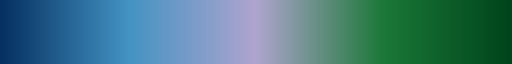

In [43]:
cell_types_cmap = cmap.from_list('',[cell_type_colors[cell_type] for cell_type in cell_types])

cell_types_cmap

____

____

____

In [44]:
anno_sub = adata.obs[adata.obs['damid']]

anno_sub.shape

(5912, 19)

Text(0.5, 1.0, 'CAGMECP2Dam126')

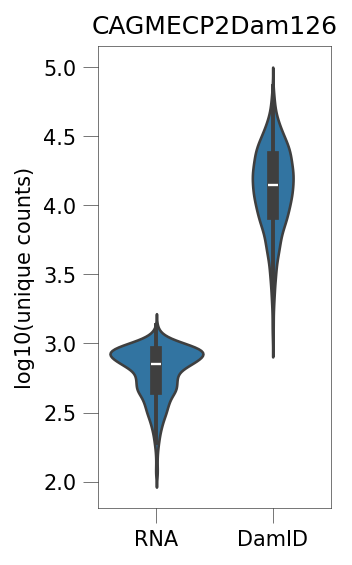

In [45]:
X = np.tile(['RNA','DamID'],(anno_sub['construct_flattened'] == 'CAGMECP2Dam126').sum())
y = np.log10(np.hstack(anno_sub.loc[anno_sub['construct_flattened'] == 'CAGMECP2Dam126',['total_counts','dam_counts']].values))

f, ax = plt.subplots(figsize=(2,4))

sns.violinplot(x=X, y=y)

ax.set_ylabel('log10(unique counts)')
ax.set_title('CAGMECP2Dam126')

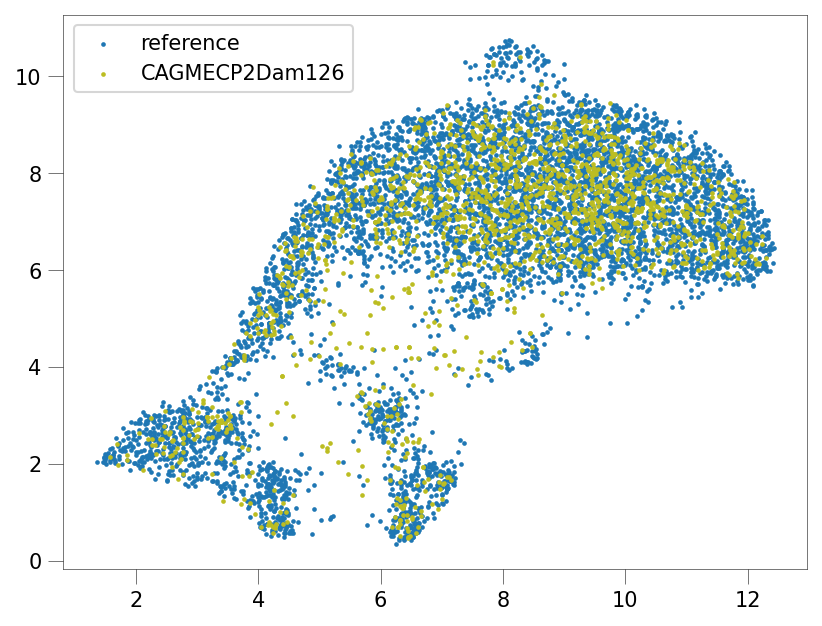

In [46]:
X, y = adata.obsm['X_umap_ref'].T
idx = adata.obs['construct_flattened'] == 'CAGMECP2Dam126'

f, ax = plt.subplots()

sns.scatterplot(x=X[~idx], 
                y=y[~idx],
                s=5,
                lw=0,
                color=COLORS[0],
                label='reference'
)
sns.scatterplot(x=X[idx], 
                y=y[idx],
                s=5,
                lw=0,
                color=COLORS[8],
                label='CAGMECP2Dam126'
)
ax.legend()

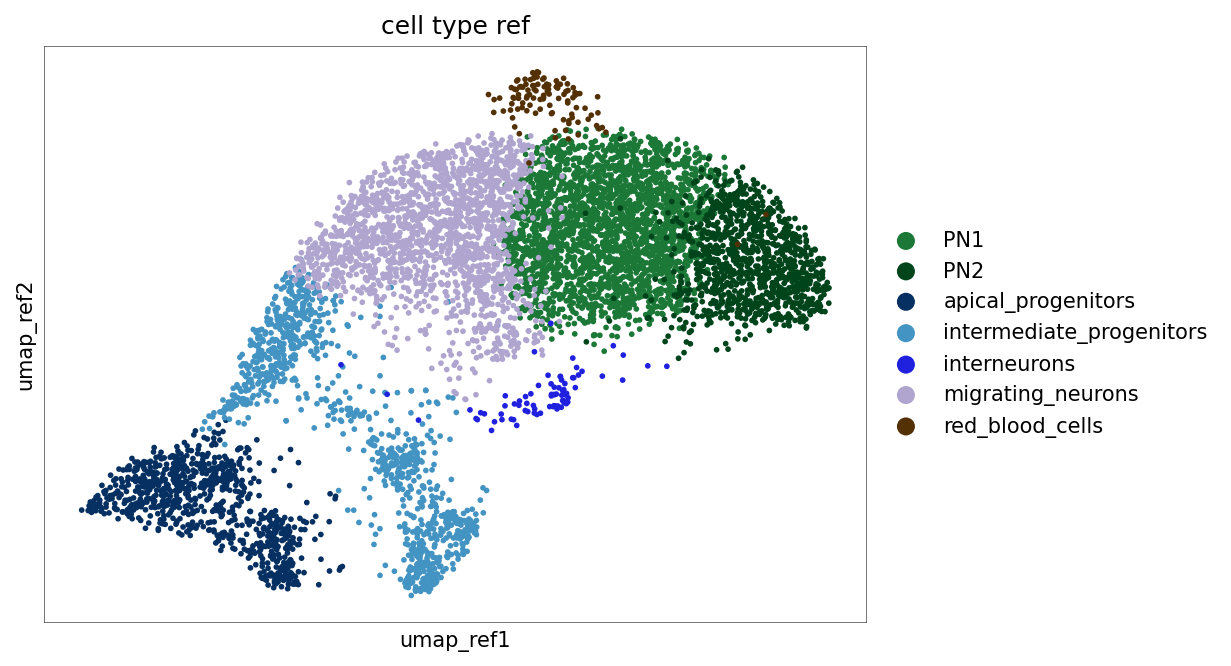

In [49]:
sc.pl.scatter(adata, 
            color='cell_type_ref',
            basis='umap_ref',
              size=30
)

Text(0.5, 1.0, 'monocle_pseudotime_ref')

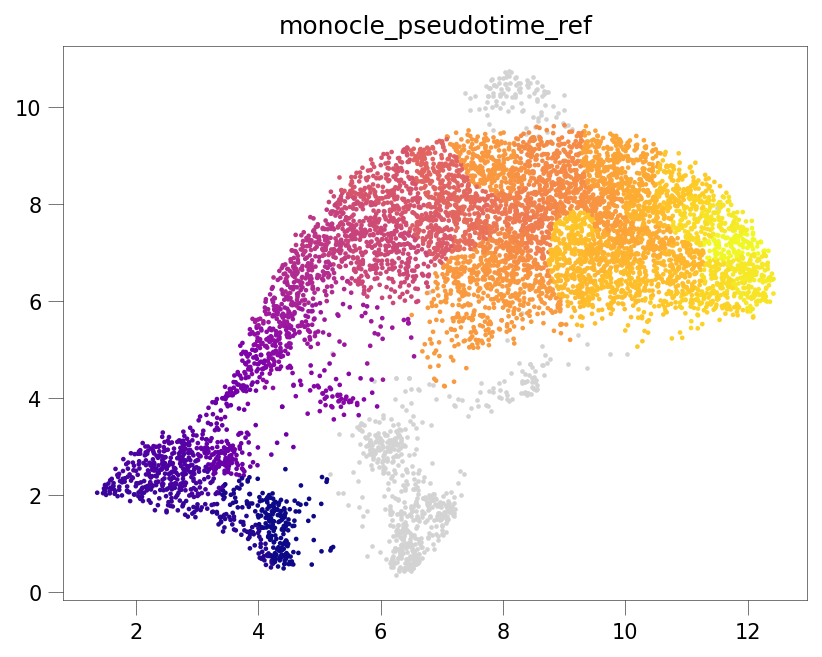

In [50]:
X, y = adata.obsm['X_umap_ref'].T
idx = ~adata.obs['monocle_pseudotime_ref'].isna()

f, ax = plt.subplots()

ax.scatter(X[~idx], 
           y[~idx],
           s=5,
           lw=0,
           color='lightgrey',
)

ax.scatter(X[idx], 
           y[idx], 
           c=adata.obs['monocle_pseudotime_ref'][idx],
           cmap='plasma',
           s=5,
           lw=0)

ax.set_title(idx.name)

Text(0.5, 0, 'Chromosome 2 (Mb)')

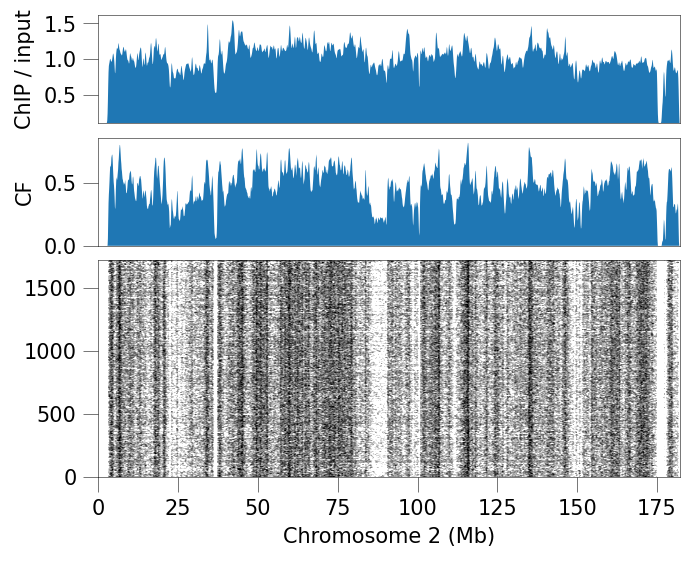

In [54]:
chrom = '2'

xaxis = np.arange(0,chromsizes[chrom],100_000) / 1e6

f, ax = plt.subplots(3, 1, figsize=(5, 4), gridspec_kw={'height_ratios':[.2,.2,.4],'hspace':.1})

y = oe_chip_100kb_smooth_mean[chrom]
ax[0].fill_between(xaxis, y)

obs_names = adata.obs[(adata.obs['damid'] == True) & (adata.obs['construct_flattened'] == 'CAGMECP2Dam126')].index

np.random.seed(0)
rand_idx = np.random.choice(obs_names.size, obs_names.size,replace=False)
X = np.array([oe_dam_100kb_smooth[obs_name][chrom] for obs_name in obs_names[rand_idx]])

ax[1].fill_between(xaxis, (X > 1).mean(0))

ax[2].imshow(np.log2(X),
             aspect='auto', 
             vmin=-.75, 
             vmax=.75, 
             cmap='binary', extent=[0,xaxis[-1],0,X.shape[0]]
)


for i in (0,1):
    ax[i].margins(x=0)
    ax[i].set_ylim(0)
    ax[i].set_xticks([])
    
ax[0].set_ylim(.1)

ax[0].set_ylabel('ChIP / input')
ax[1].set_ylabel('CF')

ax[-1].set_xlabel(f"Chromosome {chrom} (Mb)")

Text(0, 0.5, 'OE(MeCP2-Dam126)')

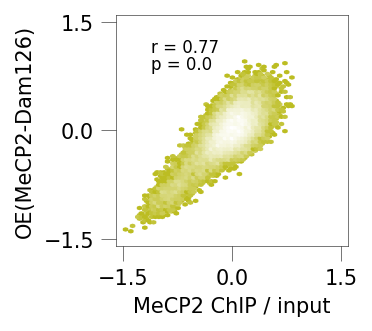

In [55]:
X = np.hstack(list(oe_chip_100kb_mean.values()))

obs_names = adata.obs[(adata.obs['damid'] == True) & (adata.obs['construct_flattened'] == 'CAGMECP2Dam126')].index
y = np.mean([np.hstack(list(oe_dam_100kb[obs_name].values())) for obs_name in obs_names], axis=0)

idx = (X > .101) & (y > .101)
X = np.log2(X[idx])
y = np.log2(y[idx])

f, ax = plt.subplots(figsize=(2,2))

ax.hexbin(X, 
          y, 
          bins='log',
          cmap=cmap.from_list('',[COLORS[8],'white']),
          gridsize=100,
          mincnt=2
)

rho, p = stats.pearsonr(X, y)
ax.text(0.15, 0.90, f'r = {rho:.2f}', transform=ax.transAxes, 
        fontsize=8, verticalalignment='top', horizontalalignment='left')
ax.text(0.15, 0.825, f'p = {p:.3}', transform=ax.transAxes, 
        fontsize=8, verticalalignment='top', horizontalalignment='left')

ax.set_xticks(np.arange(-1.5,1.6,1.5))
ax.set_yticks(np.arange(-1.5,1.6,1.5))

ax.set_xlim(-1.6,1.6)
ax.set_ylim(-1.6,1.6)

ax.set_xlabel('MeCP2 ChIP / input')
ax.set_ylabel('OE(MeCP2-Dam126)')

In [56]:
mecp2_up_gene_ids = deseq_mecp2[(deseq_mecp2['log2FoldChange'] > .2) & (deseq_mecp2['pvalue'] < 0.05)].index
mecp2_down_gene_ids = deseq_mecp2[(deseq_mecp2['log2FoldChange'] < -.2) & (deseq_mecp2['pvalue'] < 0.05)].index
mecp2_unaffected_gene_ids = deseq_mecp2.loc[(deseq_mecp2['pvalue'] > 0.05) & 
                                (deseq_mecp2['log2FoldChange'] < .2) & 
                                (deseq_mecp2['log2FoldChange'] > -.2)
].index

mecp2_up_gene_ids.size, mecp2_down_gene_ids.size, mecp2_unaffected_gene_ids.size

(417, 373, 5801)

[Text(0, 0, '-100'),
 Text(100, 0, 'TSS'),
 Text(200, 0, 'TES'),
 Text(300, 0, '100Kb')]

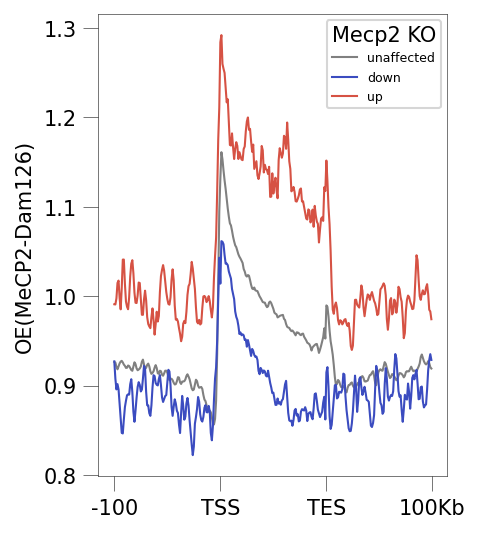

In [59]:
window = 100_000

f, ax = plt.subplots(figsize=(3,4), dpi=150)

sample = 'MeCP2_Dam126_all'

labels = ['unaffected','down','up']
for i,gene_ids in enumerate([mecp2_unaffected_gene_ids,mecp2_down_gene_ids,mecp2_up_gene_ids]):
    regions = gtf.loc[gene_ids,['Chromosome','Start','End']].values
    strand = gtf.loc[gene_ids,'Strand'].values

    a2d, bounds = scct.scale_regions(regions, oe_combined_1kb_smooth[sample], 1_000, window, strand=strand)
    a2d = a2d[bounds]
    
    
    ax.plot(a2d.mean(0), color=['grey','#3b4cc0','#d65244'][i], lw=1, label=f"{labels[i]}")
    
ax.legend(title='Mecp2 KO', prop={'size':6}, bbox_to_anchor=(1,1))

ax.set_ylabel('OE(MeCP2-Dam126)')
ax.set_xticks([0,100,200,300])
ax.set_xticklabels([-100,'TSS','TES','100Kb'])

In [60]:
ilad_var_ids = gene_class.loc[gene_class['class'] == 'iLAD','Accession']
lad_var_ids = gene_class.loc[gene_class['class'] == 'LAD','Accession']

[Text(0, 0, '-100'),
 Text(100, 0, 'TSS'),
 Text(200, 0, 'TES'),
 Text(300, 0, '100Kb')]

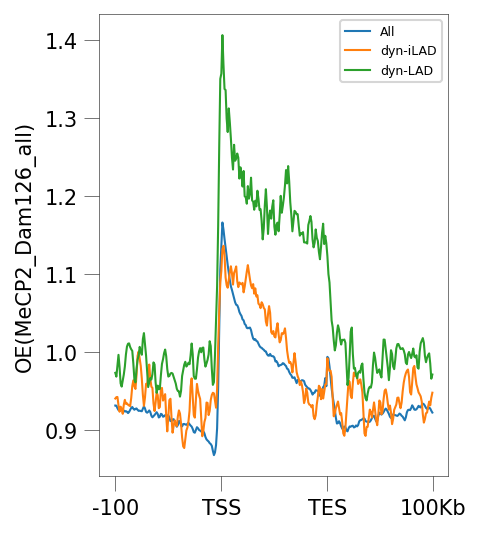

In [61]:
window = 100_000

f, ax = plt.subplots(figsize=(3,4), dpi=150)

sample = 'MeCP2_Dam126_all'

labels = ['All','dyn-iLAD','dyn-LAD']
for i,gene_ids in enumerate([deseq_mecp2.index,ilad_var_ids,lad_var_ids]):
    regions = gtf.loc[gene_ids,['Chromosome','Start','End']].values
    strand = gtf.loc[gene_ids,'Strand'].values

    a2d, bounds = scct.scale_regions(regions, oe_combined_1kb_smooth[sample], 1_000, window, strand=strand)
    a2d = a2d[bounds]
    
    
    ax.plot(a2d.mean(0), color=COLORS[i], lw=1, label=f"{labels[i]}")
    
ax.legend(prop={'size':6}, bbox_to_anchor=(1,1))

ax.set_ylabel(f"OE({sample})")
ax.set_xticks([0,100,200,300])
ax.set_xticklabels([-100,'TSS','TES','100Kb'])

[Text(0, 0, '-100'),
 Text(100, 0, 'TSS'),
 Text(200, 0, 'TES'),
 Text(300, 0, '100Kb')]

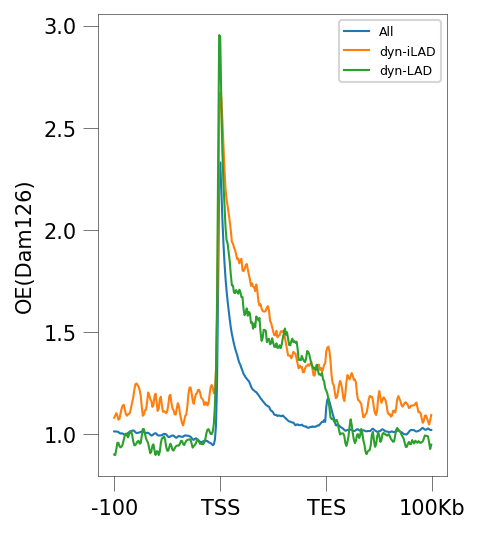

In [62]:
window = 100_000

f, ax = plt.subplots(figsize=(3,4), dpi=150)

sample = 'Dam126'

labels = ['All','dyn-iLAD','dyn-LAD']
for i,gene_ids in enumerate([deseq_mecp2.index,ilad_var_ids,lad_var_ids]):
    regions = gtf.loc[gene_ids,['Chromosome','Start','End']].values
    strand = gtf.loc[gene_ids,'Strand'].values

    a2d, bounds = scct.scale_regions(regions, oe_combined_1kb_smooth[sample], 1_000, window, strand=strand)
    a2d = a2d[bounds]
    
    
    ax.plot(a2d.mean(0), color=COLORS[i], lw=1, label=f"{labels[i]}")
    
ax.legend(prop={'size':6}, bbox_to_anchor=(1,1))

ax.set_ylabel(f"OE({sample})")
ax.set_xticks([0,100,200,300])
ax.set_xticklabels([-100,'TSS','TES','100Kb'])

Text(0.5, 1.0, 'CAGMECP2Dam126')

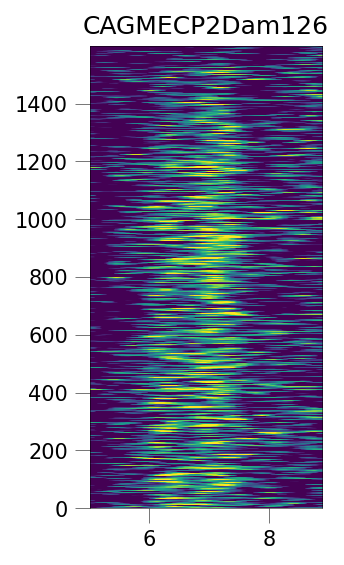

In [64]:
chrom = '16'
s = 5_000_000
e = 9_000_000

var_name = 'Rbfox1'

s_bin = s // 100_000
e_bin = e // 100_000

xaxis = np.arange(s,e,100_000) / 1e6

construct = 'CAGMECP2Dam126'
obs_names = adata.obs[(adata.obs['damid'] == True) & 
                      (adata.obs['construct_flattened'] == construct) & 
                      (~adata.obs['monocle_pseudotime_ref'].isna())
].sort_values('monocle_pseudotime_ref').index
X = np.log2([oe_dam_100kb_smooth[obs_name][chrom][s_bin:e_bin] for obs_name in obs_names])


f, ax = plt.subplots(figsize=(2,4),)

ax.imshow(X, 
          aspect='auto', 
          cmap='viridis',
          vmin=-.25, 
          vmax=.75, 
          extent=[xaxis[0],xaxis[-1],0,X.shape[0]]
)
ax.set_title(construct)

Text(0.5, 1.0, 'Dam-LMNB1')

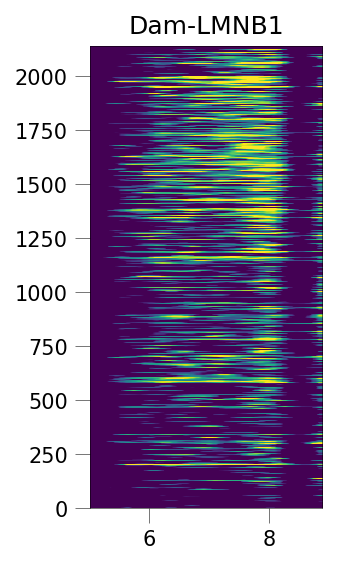

In [65]:
construct = 'Dam-LMNB1'
obs_names = adata.obs[(adata.obs['damid'] == True) & 
                      (adata.obs['construct_flattened'] == construct) & 
                      (~adata.obs['monocle_pseudotime_ref'].isna())
].sort_values('monocle_pseudotime_ref').index
X = np.log2([oe_dam_100kb_smooth[obs_name][chrom][s_bin:e_bin] for obs_name in obs_names])

f, ax = plt.subplots(figsize=(2,4),)

ax.imshow(X, 
          aspect='auto', 
          cmap='viridis',
          vmin=-.5, 
          vmax=.1, 
          extent=[xaxis[0],xaxis[-1],0,X.shape[0]]
)
ax.set_title(construct)

In [87]:
samples = ['Dam126','MeCP2_Dam126_all','MeCP2_ChIP',
           '5hmC_npc','5hmC_neurons']

regions = gtf.loc[gene_class['Accession'],['Chromosome','Start','End']].values

pad = 5 #nbins 
for sample in samples:
    X = list()
    for c,s,e in regions:
        s_bin = s // 1_000
        e_bin = e // 1_000
        X.append(oe_combined_1kb_smooth[sample][c][s_bin-pad:e_bin+pad].mean())

    gene_class[sample] = X

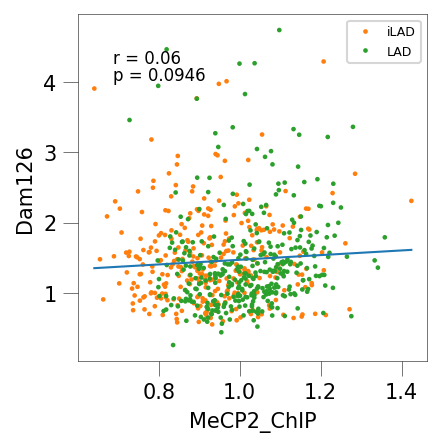

In [80]:
X = gene_class.loc[:,'MeCP2_ChIP']
y = gene_class.loc[:,'Dam126']
hue = gene_class.loc[:,'class']

f, ax = plt.subplots(figsize=(3,3))

sns.regplot(x=X, 
            y=y, 
            scatter_kws={'s':0}, 
            line_kws={'lw':1},
            ci=None
)
sns.scatterplot(x=X, 
                y=y, 
                hue=hue, 
                palette=COLORS[1:],
                lw=0, 
                s=5
)

rho, p = stats.pearsonr(X, y)
ax.text(0.1, 0.90, f'r = {rho:.2f}', transform=ax.transAxes, 
        fontsize=8, verticalalignment='top', horizontalalignment='left')
ax.text(0.1, 0.85, f'p = {p:.3}', transform=ax.transAxes, 
        fontsize=8, verticalalignment='top', horizontalalignment='left')

ax.legend(prop={'size':6})

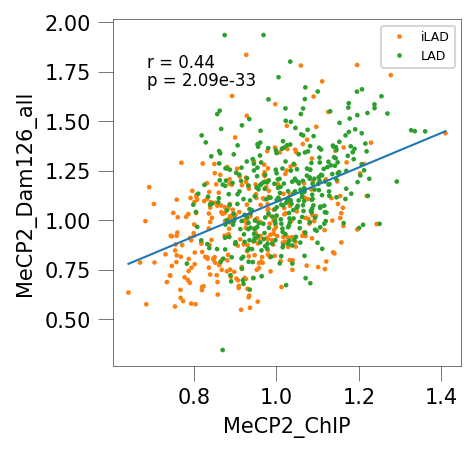

In [74]:
X = gene_class.loc[:,'MeCP2_ChIP']
y = gene_class.loc[:,'MeCP2_Dam126_all']
hue = gene_class.loc[:,'class']

f, ax = plt.subplots(figsize=(3,3))

sns.regplot(x=X, 
            y=y, 
            scatter_kws={'s':0}, 
            line_kws={'lw':1},
            ci=None
)
sns.scatterplot(x=X, 
                y=y, 
                hue=hue, 
                palette=COLORS[1:],
                lw=0, 
                s=5
)

rho, p = stats.pearsonr(X, y)
ax.text(0.1, 0.90, f'r = {rho:.2f}', transform=ax.transAxes, 
        fontsize=8, verticalalignment='top', horizontalalignment='left')
ax.text(0.1, 0.85, f'p = {p:.3}', transform=ax.transAxes, 
        fontsize=8, verticalalignment='top', horizontalalignment='left')

ax.legend(prop={'size':6})

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


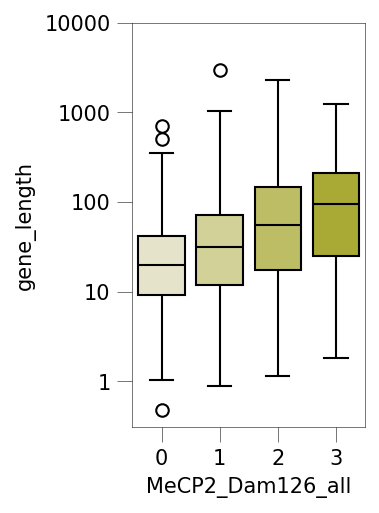

In [85]:
y = gene_class.loc[:,'MeCP2_Dam126_all']
c = np.log10(gene_class.loc[:,'gene_length'])

n_bins = 4  # This will create quartiles (0-25%, 25-50%, 50-75%, 75-100%)

# Compute bin edges (excluding min and max to avoid an extra bin)
percentiles = np.percentile(y, np.linspace(0, 100, n_bins + 1))

# Assign each value to a percentile bin
bin_indices = np.digitize(y, percentiles, right=True)

# Adjust bin indices to be 0-based
bin_indices -= 1

bin_indices[bin_indices < 0] = 0


f, ax = plt.subplots(figsize=(2,3.5))

sns.boxplot(x=bin_indices, 
            y=c, 
            palette=generate_color_gradient('#eae8c5',COLORS[8], 4), 
            linecolor='k'
)

ax.set_xlabel(y.name)
ax.set_ylabel(c.name)

ticks = np.arange(3,8)
ax.set_yticks(ticks,(10**ticks)//1_000)

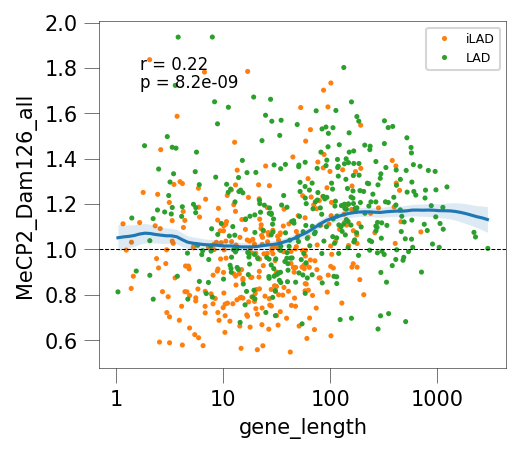

In [88]:
X = np.log10(gene_class.loc[:,'gene_length'])
y = gene_class.loc[:,'MeCP2_Dam126_all'] #/ gene_class['Dam126']
hue = gene_class.loc[:,'class']

idx = (X > np.log10(1_000)) #& (X < np.log10(1_000_000))
X = X[idx]
y = y[idx]
hue = hue[idx]

xhat, yhat, yhat_sem = sccu.RNR(X.values, y.values, .25, .05)

f, ax = plt.subplots(figsize=(3.5,3))

sns.scatterplot(x=X, 
                y=y, 
                hue=hue, 
                palette=COLORS[1:],
                lw=0, 
                s=6
)
# sns.regplot(x=X, 
#                 y=y, 
#             order=2,
#             scatter_kws={'s':0},
# )

ax.plot(xhat, 
        yhat, 
        color=COLORS[0],
)
ax.fill_between(xhat, 
                yhat - yhat_sem, 
                yhat + yhat_sem, 
                alpha=.15,
                lw=0,
                color=COLORS[0])

ax.axhline(1, lw=.5, ls='--', color='k')
xticks = np.arange(3,7)
ax.set_xticks(xticks,(10**xticks)//1_000)
#ax.set_yticks(np.arange(.5,2,.25))

rho, p = stats.pearsonr(X, y)
ax.text(0.1, 0.90, f'r = {rho:.2f}', transform=ax.transAxes, 
        fontsize=8, verticalalignment='top', horizontalalignment='left')
ax.text(0.1, 0.85, f'p = {p:.3}', transform=ax.transAxes, 
        fontsize=8, verticalalignment='top', horizontalalignment='left')

ax.legend(prop={'size':6})

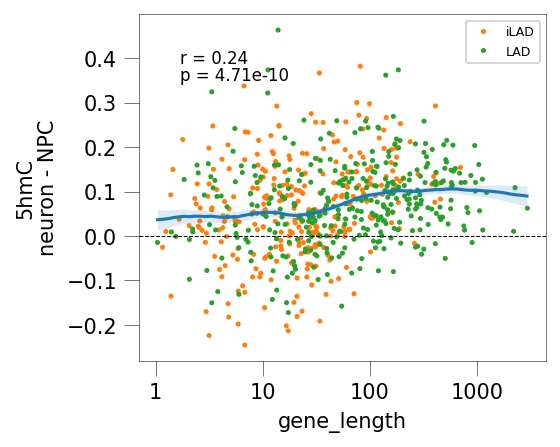

In [89]:
X = np.log10(gene_class.loc[:,'gene_length'])
y = gene_class.loc[:,'5hmC_neurons'] - gene_class.loc[:,'5hmC_npc']
hue = gene_class.loc[:,'class']

idx = (X > np.log10(1_000)) #& (X < np.log10(1_000_000))
X = X[idx]
y = y[idx]
hue = hue[idx]

xhat, yhat, yhat_sem = sccu.RNR(X.values, y.values, .25, .05)

f, ax = plt.subplots(figsize=(3.5,3))

sns.scatterplot(x=X, 
                y=y, 
                hue=hue, 
                palette=COLORS[1:],
                lw=0, 
                s=6
)
# sns.regplot(x=X, 
#                 y=y, 
#             order=2,
#             scatter_kws={'s':0},
# )

ax.plot(xhat, 
        yhat, 
        color=COLORS[0],
)
ax.fill_between(xhat, 
                yhat - yhat_sem, 
                yhat + yhat_sem, 
                alpha=.15,
                lw=0,
                color=COLORS[0])

ax.axhline(0, lw=.5, ls='--', color='k')
xticks = np.arange(3,7)
ax.set_xticks(xticks,(10**xticks)//1_000)
#ax.set_yticks(np.arange(.5,2,.25))

ax.set_ylabel('5hmC\nneuron - NPC')

rho, p = stats.pearsonr(X, y)
ax.text(0.1, 0.90, f'r = {rho:.2f}', transform=ax.transAxes, 
        fontsize=8, verticalalignment='top', horizontalalignment='left')
ax.text(0.1, 0.85, f'p = {p:.3}', transform=ax.transAxes, 
        fontsize=8, verticalalignment='top', horizontalalignment='left')

ax.legend(prop={'size':6})

______

In [90]:
scv.pp.moments(adata, 
               n_pcs=30, 
               n_neighbors=30, 
               add_layers=['count_abundance_genes_from_celseq2_data'],
               use_rep='X_pca_harmony'
)

computing neighbors
    finished (0:00:08) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:02) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
--> added 
    'Mc' moments of count_abundance_genes_from_celseq2_data abundances (adata.layers)


In [92]:
bcs = anno_sub[(~anno_sub['monocle_pseudotime_ref'].isna()) & (anno_sub['construct_flattened'] == 'Dam-LMNB1')].sort_values('monocle_pseudotime_ref').index

adata_lb1 = sc.AnnData(adata[bcs].X, obs=adata[bcs].obs, var=adata[bcs].var)
adata_lb1.layers['count_abundance_genes_from_celseq2_data'] = adata[bcs].layers['count_abundance_genes_from_celseq2_data']
adata_lb1.layers['spliced'] = adata[bcs].layers['spliced']
adata_lb1.layers['unspliced'] = adata[bcs].layers['unspliced']
adata_lb1.layers['damid'] = adata[bcs].layers['damid']

adata_lb1

AnnData object with n_obs × n_vars = 2139 × 11716
    obs: 'limsid', 'indexnr', 'damid2_barcodenr', 'celseq2_barcodenr', 'iue', 'collection', 'embryo', 'construct', 'construct_flattened', 'n_genes_by_counts', 'total_counts', 'dam_counts', 'damid', 'leiden', 'leiden_ref', 'cell_type_ref', 'monocle_pseudotime', 'monocle_pseudotime_ref', 'latent_time'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'n_cells_by_counts', 'dispersions', 'highly_variable'
    layers: 'count_abundance_genes_from_celseq2_data', 'spliced', 'unspliced', 'damid'

In [93]:
sc.tl.pca(adata_lb1, use_highly_variable=True, svd_solver='arpack', n_comps=100, random_state=0)

In [94]:
Z = harmonize(adata_lb1.obsm['X_pca'], adata_lb1.obs, batch_key = 'limsid', random_state=0)
adata_lb1.obsm['X_pca_harmony'] = Z

	Initialization is completed.
	Completed 1 / 10 iteration(s).
	Completed 2 / 10 iteration(s).
	Completed 3 / 10 iteration(s).
	Completed 4 / 10 iteration(s).
	Completed 5 / 10 iteration(s).
	Completed 6 / 10 iteration(s).
	Completed 7 / 10 iteration(s).
	Completed 8 / 10 iteration(s).
	Completed 9 / 10 iteration(s).
	Completed 10 / 10 iteration(s).


In [95]:
scv.pp.moments(adata_lb1, add_layers=['count_abundance_genes_from_celseq2_data','damid'], 
               n_pcs=30, 
               n_neighbors=10, 
               use_rep='X_pca_harmony'
)

computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
--> added 
    'Mc' moments of count_abundance_genes_from_celseq2_data abundances (adata.layers)
--> added 
    'Md' moments of damid abundances (adata.layers)


In [96]:
bcs = anno_sub[(~anno_sub['monocle_pseudotime_ref'].isna()) & (anno_sub['construct_flattened'] == 'CAGMECP2Dam126')].sort_values('monocle_pseudotime_ref').index

adata_mecp2 = sc.AnnData(adata[bcs].X, obs=adata[bcs].obs, var=adata[bcs].var)
adata_mecp2.layers['count_abundance_genes_from_celseq2_data'] = adata[bcs].layers['count_abundance_genes_from_celseq2_data']
adata_mecp2.layers['spliced'] = adata[bcs].layers['spliced']
adata_mecp2.layers['unspliced'] = adata[bcs].layers['unspliced']
adata_mecp2.layers['damid'] = adata[bcs].layers['damid']

adata_mecp2

AnnData object with n_obs × n_vars = 1599 × 11716
    obs: 'limsid', 'indexnr', 'damid2_barcodenr', 'celseq2_barcodenr', 'iue', 'collection', 'embryo', 'construct', 'construct_flattened', 'n_genes_by_counts', 'total_counts', 'dam_counts', 'damid', 'leiden', 'leiden_ref', 'cell_type_ref', 'monocle_pseudotime', 'monocle_pseudotime_ref', 'latent_time'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'n_cells_by_counts', 'dispersions', 'highly_variable'
    layers: 'count_abundance_genes_from_celseq2_data', 'spliced', 'unspliced', 'damid'

In [97]:
sc.tl.pca(adata_mecp2, use_highly_variable=True, svd_solver='arpack', n_comps=100, random_state=0)

In [98]:
Z = harmonize(adata_mecp2.obsm['X_pca'], adata_mecp2.obs, batch_key = 'limsid', random_state=0)
adata_mecp2.obsm['X_pca_harmony'] = Z

	Initialization is completed.
	Completed 1 / 10 iteration(s).
	Completed 2 / 10 iteration(s).
	Completed 3 / 10 iteration(s).
	Completed 4 / 10 iteration(s).
	Completed 5 / 10 iteration(s).
	Completed 6 / 10 iteration(s).
Reach convergence after 6 iteration(s).


In [99]:
scv.pp.moments(adata_mecp2, add_layers=['count_abundance_genes_from_celseq2_data','damid'], 
               n_pcs=30, 
               n_neighbors=30, 
               use_rep='X_pca_harmony'
)

computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
--> added 
    'Mc' moments of count_abundance_genes_from_celseq2_data abundances (adata.layers)
--> added 
    'Md' moments of damid abundances (adata.layers)


In [100]:
bcs = anno_sub[(~anno_sub['monocle_pseudotime_ref'].isna()) & (anno_sub['construct_flattened'] == 'Dam-only')].sort_values('monocle_pseudotime_ref').index

adata_dam = sc.AnnData(adata[bcs].X, obs=adata[bcs].obs, var=adata[bcs].var)
adata_dam.layers['count_abundance_genes_from_celseq2_data'] = adata[bcs].layers['count_abundance_genes_from_celseq2_data']
adata_dam.layers['spliced'] = adata[bcs].layers['spliced']
adata_dam.layers['unspliced'] = adata[bcs].layers['unspliced']
adata_dam.layers['damid'] = adata[bcs].layers['damid']

adata_dam

AnnData object with n_obs × n_vars = 1664 × 11716
    obs: 'limsid', 'indexnr', 'damid2_barcodenr', 'celseq2_barcodenr', 'iue', 'collection', 'embryo', 'construct', 'construct_flattened', 'n_genes_by_counts', 'total_counts', 'dam_counts', 'damid', 'leiden', 'leiden_ref', 'cell_type_ref', 'monocle_pseudotime', 'monocle_pseudotime_ref', 'latent_time'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'n_cells_by_counts', 'dispersions', 'highly_variable'
    layers: 'count_abundance_genes_from_celseq2_data', 'spliced', 'unspliced', 'damid'

In [101]:
sc.tl.pca(adata_dam, use_highly_variable=True, svd_solver='arpack', n_comps=100, random_state=0)

In [102]:
Z = harmonize(adata_dam.obsm['X_pca'], adata_dam.obs, batch_key = 'limsid', random_state=0)
adata_dam.obsm['X_pca_harmony'] = Z

	Initialization is completed.
	Completed 1 / 10 iteration(s).
	Completed 2 / 10 iteration(s).
	Completed 3 / 10 iteration(s).
	Completed 4 / 10 iteration(s).
	Completed 5 / 10 iteration(s).
	Completed 6 / 10 iteration(s).
	Completed 7 / 10 iteration(s).
	Completed 8 / 10 iteration(s).
	Completed 9 / 10 iteration(s).
Reach convergence after 9 iteration(s).


In [103]:
scv.pp.moments(adata_dam, add_layers=['count_abundance_genes_from_celseq2_data','damid'], 
               n_pcs=30, 
               n_neighbors=30, 
               use_rep='X_pca_harmony'
)

computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
--> added 
    'Mc' moments of count_abundance_genes_from_celseq2_data abundances (adata.layers)
--> added 
    'Md' moments of damid abundances (adata.layers)


_____

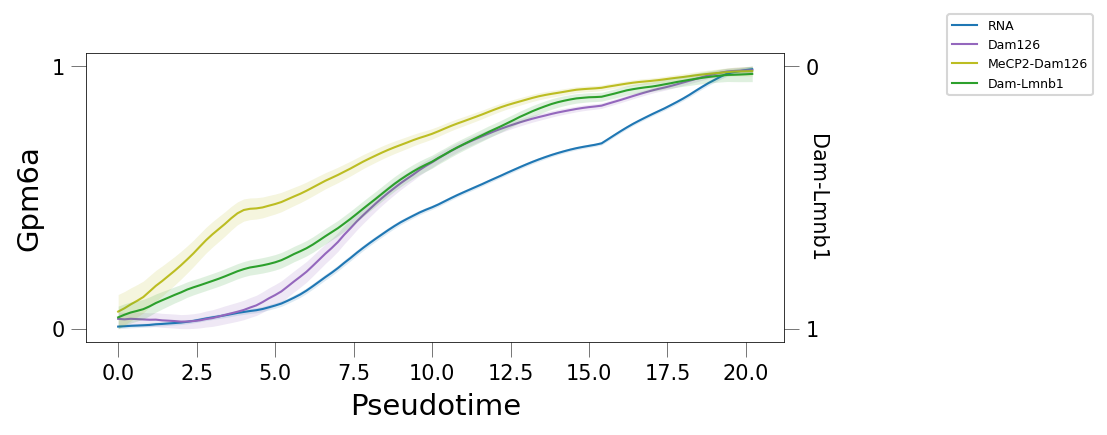

In [109]:
for var_name in ['Gpm6a']:
    f, ax = plt.subplots(figsize=(6,2.5))

    #RNA
    obs_names = adata.obs_names[~adata.obs['monocle_pseudotime_ref'].isna()]
    X = adata[obs_names].obs['monocle_pseudotime_ref']
    Mc = np.ravel(adata[obs_names,var_name].layers['Mc'].toarray())

    xhat, yhat, yhat_sem = sccu.RNR(X=X, 
                                    y=Mc, 
                                    _RADIUS=2, 
                                    step=.2
    )
    yhat_sem_min = ((yhat - yhat_sem) - (yhat - yhat_sem).min()) / ((yhat + yhat_sem).max() - (yhat - yhat_sem).min())
    yhat_sem_plus = ((yhat + yhat_sem) - (yhat - yhat_sem).min()) / ((yhat + yhat_sem).max() - (yhat - yhat_sem).min())
    yhat = (yhat - (yhat - yhat_sem).min()) / ((yhat + yhat_sem).max() - (yhat - yhat_sem).min())

    ax.plot(xhat, 
            yhat, 
            lw=1,
            color=COLORS[0], 
            label='RNA'
    )
    ax.fill_between(xhat, 
                    yhat_sem_min, 
                    yhat_sem_plus, 
                    color=COLORS[0], 
                    alpha=.15,
                    lw=0
    )

    #Dam126
    X = adata_dam.obs['monocle_pseudotime_ref']
    Md = np.ravel(adata_dam[:,var_name].layers['Md'].toarray())

    xhat, yhat, yhat_sem = sccu.RNR(X=X, 
                                    y=Md, 
                                    _RADIUS=2, 
                                    step=.2
    )
    yhat_sem_min = ((yhat - yhat_sem) - (yhat - yhat_sem).min()) / ((yhat + yhat_sem).max() - (yhat - yhat_sem).min())
    yhat_sem_plus = ((yhat + yhat_sem) - (yhat - yhat_sem).min()) / ((yhat + yhat_sem).max() - (yhat - yhat_sem).min())
    yhat = (yhat - (yhat - yhat_sem).min()) / ((yhat + yhat_sem).max() - (yhat - yhat_sem).min())

    ax.plot(xhat, 
            yhat, 
            lw=1,
            color=COLORS[4],
            label='Dam126'
    )
    ax.fill_between(xhat, 
                    yhat_sem_min, 
                    yhat_sem_plus, 
                    color=COLORS[4], 
                    alpha=.15,
                    lw=0
    )

    #Dam-LMNB1
    X = adata_lb1.obs['monocle_pseudotime_ref']
    Md = np.ravel(adata_lb1[:,var_name].layers['Md'].toarray())

    xhat, yhat, yhat_sem = sccu.RNR(X=X, 
                                    y=Md, 
                                    _RADIUS=2, 
                                    step=.2
    )

    yhat_sem_min = ((yhat - yhat_sem) - (yhat - yhat_sem).min()) / ((yhat + yhat_sem).max() - (yhat - yhat_sem).min())
    yhat_sem_plus = ((yhat + yhat_sem) - (yhat - yhat_sem).min()) / ((yhat + yhat_sem).max() - (yhat - yhat_sem).min())
    yhat = (yhat - (yhat - yhat_sem).min()) / ((yhat + yhat_sem).max() - (yhat - yhat_sem).min())

    #plot Dam-lb1 to right y-axis
    ax1 = ax.twinx()

    ax1.plot(xhat, 
            yhat, 
            lw=1,
            color=COLORS[2],
            label='Dam-Lmnb1'
    )
    ax1.fill_between(xhat, 
                    yhat_sem_min, 
                    yhat_sem_plus, 
                    color=COLORS[2], 
                    alpha=.15,
                    lw=0
    )
    ax1.invert_yaxis()


    #MeCP2-Dam126
    X = adata_mecp2.obs['monocle_pseudotime_ref']
    Md = np.ravel(adata_mecp2[:,var_name].layers['Md'].toarray())

    xhat, yhat, yhat_sem = sccu.RNR(X=X, 
                                    y=Md, 
                                    _RADIUS=2, 
                                    step=.2
    )
    yhat_sem_min = ((yhat - yhat_sem) - (yhat - yhat_sem).min()) / ((yhat + yhat_sem).max() - (yhat - yhat_sem).min())
    yhat_sem_plus = ((yhat + yhat_sem) - (yhat - yhat_sem).min()) / ((yhat + yhat_sem).max() - (yhat - yhat_sem).min())
    yhat = (yhat - (yhat - yhat_sem).min()) / ((yhat + yhat_sem).max() - (yhat - yhat_sem).min())

    ax.plot(xhat, 
            yhat, 
            lw=1,
            color=COLORS[8],
            label='MeCP2-Dam126'
    )
    ax.fill_between(xhat, 
                    yhat_sem_min, 
                    yhat_sem_plus, 
                    color=COLORS[8], 
                    alpha=.15,
                    lw=0
    )

    ax.set_ylabel(var_name, fontsize=14)
    ax.set_xlabel('Pseudotime', fontsize=14)
    ax.set_yticks([0,1])
    ax1.set_yticks([0,1])
    ax1.set_ylabel('Dam-Lmnb1', rotation=-90)
    f.legend(prop={'size':6}, bbox_to_anchor=(1.25,1))

______

In [111]:
activating_var_names = np.array(['A730020E08Rik',
'Adcy1',
'Ank3',
'Arpp21',
'Atp2b1',
'Atrnl1',
'Bach1',
'Bcl11a',
'Bhlhe22',
'Cadps',
'Celf2',
'Chl1',
'Clstn2',
'Cnr1',
'Csrnp3',
'Dpy19l1',
'Dpysl3',
'Edil3',
'Epha3',
'Fam49a',
'Flrt2',
'Frmd4b',
'Fry',
'Gabra2',
'Gabrb3',
'Gpm6a',
'Gpr85',
'Gria2',
'Hecw1',
'Herc3',
'Itpr1',
'Jakmip2',
'Kcnn2',
'Kcnq3',
'Lrrtm1',
'Lsamp',
'Lypd6',
'Mef2c',
'Nap1l5',
'Nav3',
'Ndst3',
'Neurod6',
'Nrip1',
'Nrp1',
'Nrxn1',
'Pak3',
'Pcdh9',
'Ppfia2',
'Prdm8',
'Ptprd',
'Ptpro',
'Rabgap1l',
'Rbfox1',
'Robo1',
'Robo2',
'Rspo3',
'Runx1t1',
'Satb2',
'Scn2a',
'Scn3a',
'Sh3kbp1',
'Sla',
'Snap25',
'Snap91',
'Soga3',
'Sox11',
'Sox5',
'Sptbn1',
'Srgap1',
'Syt4',
'Tbr1',
'Tenm2',
'Tmsb4x',
'Tspan5',
'Tub',
])
len(activating_var_names)

75

In [112]:
min_ywindow = 0.4
max_ywindow = 0.6

X_window_activating = np.zeros((len(_activating_var_names),4))

for i,var in enumerate(tqdm(_activating_var_names)):
    #expression
    obs_names = adata.obs_names[~adata.obs['monocle_pseudotime_ref'].isna()]
    X = adata[obs_names].obs['monocle_pseudotime_ref']
    Mc = np.ravel(adata[obs_names,var].layers['Mc'].toarray())

    xhat, yhat, yhat_sem = sccu.RNR(X=X, 
                                    y=Mc, 
                                    _RADIUS=2, 
                                    step=.2
    )
    yhat = sccu.mmscale(yhat)
    window_idx = (yhat >= min_ywindow) & (yhat < max_ywindow)
    X_window_activating[i,0] = xhat[window_idx].mean()

    #Dam-Lmnb1
    X = adata_lb1.obs['monocle_pseudotime_ref']
    Md = np.ravel(adata_lb1[:,var].layers['Md'].toarray())

    xhat, yhat, yhat_sem = sccu.RNR(X=X, 
                                    y=Md, 
                                    _RADIUS=2, 
                                    step=.2
    )
    yhat = sccu.mmscale(yhat)
    window_idx = (yhat >= min_ywindow) & (yhat < max_ywindow)
    X_window_activating[i,1] = xhat[window_idx].mean()

    #Dam126
    X = adata_dam.obs['monocle_pseudotime_ref']
    Md = np.ravel(adata_dam[:,var].layers['Md'].toarray())

    xhat, yhat, yhat_sem = sccu.RNR(X=X, 
                                    y=Md, 
                                    _RADIUS=2, 
                                    step=.2
    )
    yhat = sccu.mmscale(yhat)
    window_idx = (yhat >= min_ywindow) & (yhat < max_ywindow)
    X_window_activating[i,2] = xhat[window_idx].mean()
    
    #MeCP2-Dam126
    X = adata_mecp2.obs['monocle_pseudotime_ref']
    Md = np.ravel(adata_mecp2[:,var].layers['Md'].toarray())

    xhat, yhat, yhat_sem = sccu.RNR(X=X, 
                                    y=Md, 
                                    _RADIUS=2, 
                                    step=.2
    )
    yhat = sccu.mmscale(yhat)
    window_idx = (yhat >= min_ywindow) & (yhat < max_ywindow)
    X_window_activating[i,3] = xhat[window_idx].mean()

  0%|          | 0/75 [00:00<?, ?it/s]

In [113]:
min_ywindow = 0.4
max_ywindow = 0.6

X_window_activating_rna = np.zeros((len(_activating_var_names),4))

for i,var in enumerate(tqdm(_activating_var_names)):
    #expression
    obs_names = adata.obs_names[~adata.obs['monocle_pseudotime_ref'].isna()]
    X = adata[obs_names].obs['monocle_pseudotime_ref']
    Mc = np.ravel(adata[obs_names,var].layers['Mc'].toarray())

    xhat, yhat, yhat_sem = sccu.RNR(X=X, 
                                    y=Mc, 
                                    _RADIUS=2, 
                                    step=.2
    )
    yhat = sccu.mmscale(yhat)
    window_idx = (yhat >= min_ywindow) & (yhat < max_ywindow)
    X_window_activating_rna[i,0] = xhat[window_idx].mean()

    #Dam-Lmnb1
    X = adata_lb1.obs['monocle_pseudotime_ref']
    Md = np.ravel(adata_lb1[:,var].layers['Mc'].toarray())

    xhat, yhat, yhat_sem = sccu.RNR(X=X, 
                                    y=Md, 
                                    _RADIUS=2, 
                                    step=.2
    )
    yhat = sccu.mmscale(yhat)
    window_idx = (yhat >= min_ywindow) & (yhat < max_ywindow)
    X_window_activating_rna[i,1] = xhat[window_idx].mean()

    #Dam126
    X = adata_dam.obs['monocle_pseudotime_ref']
    Md = np.ravel(adata_dam[:,var].layers['Mc'].toarray())

    xhat, yhat, yhat_sem = sccu.RNR(X=X, 
                                    y=Md, 
                                    _RADIUS=2, 
                                    step=.2
    )
    yhat = sccu.mmscale(yhat)
    window_idx = (yhat >= min_ywindow) & (yhat < max_ywindow)
    X_window_activating_rna[i,2] = xhat[window_idx].mean()
    
    #MeCP2-Dam126
    X = adata_mecp2.obs['monocle_pseudotime_ref']
    Md = np.ravel(adata_mecp2[:,var].layers['Mc'].toarray())

    xhat, yhat, yhat_sem = sccu.RNR(X=X, 
                                    y=Md, 
                                    _RADIUS=2, 
                                    step=.2
    )
    yhat = sccu.mmscale(yhat)
    window_idx = (yhat >= min_ywindow) & (yhat < max_ywindow)
    X_window_activating_rna[i,3] = xhat[window_idx].mean()

  0%|          | 0/75 [00:00<?, ?it/s]

Text(3.2, 1.5, 'p=2.2e-10')

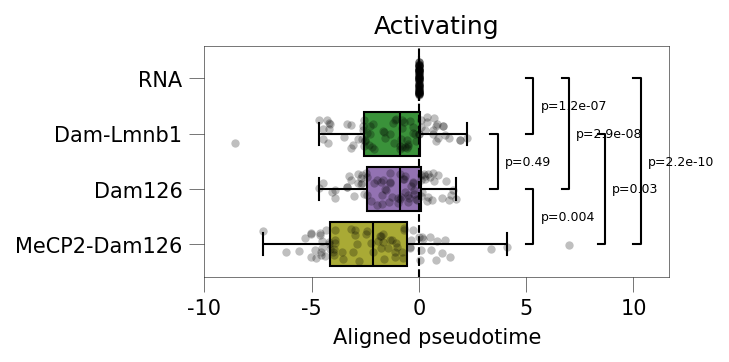

In [117]:
X = np.tile(['RNA','Dam-Lmnb1','Dam126','MeCP2-Dam126'], len(_activating_var_names))
y_norm = np.log2(np.hstack(X_window_activating) / np.hstack(X_window_activating_rna))
#y_norm = (np.hstack(X_window_activating) - np.hstack(X_window_activating_rna))

f, ax = plt.subplots(figsize=(4,2))

sns.boxplot(x=y_norm, y=X, palette=[COLORS[0],COLORS[2],COLORS[4],COLORS[8]], fliersize=0, linecolor='k')
sns.stripplot(x=y_norm, y=X, jitter=.3, size=4, color='k', alpha=.25)

ax.set_xlabel('Aligned pseudotime')
ax.set_title('Activating')

ax.axvline(0, lw=1, ls='--', color='k')

xmin, xmax = -3, 3.5
ax.set_xlim(xmin,xmax)

#ttest RNA vs Dam-Lmnb1
p = stats.ttest_ind(y_norm[X=='RNA'], y_norm[X=='Dam-Lmnb1'], equal_var=False)[1]

# annotate
y1, y2 = 0, 1  # group indices on y-axis now
x0, h = xmax - 2, .1  # adjust based on x-axis (which now holds values)
ax.plot([x0, x0+h, x0+h, x0], [y1, y1, y2, y2], lw=1, c='k')
ax.text(x0+h+.1, (y1+y2)*.5, f"p={p:.2}", va='center', ha='left', c='k', fontsize=6)

#ttest Dam-Lmnb1 vs Dam126
p = stats.ttest_ind(y_norm[X=='Dam-Lmnb1'], y_norm[X=='Dam126'], equal_var=False)[1]

y1, y2 = 1, 2  # group indices on y-axis now
x0, h = xmax - 2.5, .1  # adjust based on x-axis (which now holds values)
ax.plot([x0, x0+h, x0+h, x0], [y1, y1, y2, y2], lw=1, c='k')
ax.text(x0+h+.1, (y1+y2)*.5, f"p={p:.2}", va='center', ha='left', c='k', fontsize=6)

#ttest RNA vs Dam126
p = stats.ttest_ind(y_norm[X=='RNA'],y_norm[X=='Dam126'], equal_var=False)[1]

#annotate
y1, y2 = 0, 2  # group indices on y-axis now
x0, h = xmax - 1.5, .1  # adjust based on x-axis (which now holds values)
ax.plot([x0, x0+h, x0+h, x0], [y1, y1, y2, y2], lw=1, c='k')
ax.text(x0+h+.1, (y1+y2)*.5, f"p={p:.2}", va='center', ha='left', c='k', fontsize=6)

#ttest Dam126 vs MeCP2-Dam126
p = stats.ttest_ind(y_norm[X=='Dam126'],y_norm[X=='MeCP2-Dam126'], equal_var=False)[1]

#annotate
y1, y2 = 2, 3  # group indices on y-axis now
x0, h = xmax - 2, .1  # adjust based on x-axis (which now holds values)
ax.plot([x0, x0+h, x0+h, x0], [y1, y1, y2, y2], lw=1, c='k')
ax.text(x0+h+.1, (y1+y2)*.5, f"p={p:.2}", va='center', ha='left', c='k', fontsize=6)


#ttest Dam-Lmnb1 vs MeCP2-Dam126
p = stats.ttest_ind(y_norm[X=='Dam-Lmnb1'],y_norm[X=='MeCP2-Dam126'], equal_var=False)[1]

#annotate
y1, y2 = 1, 3  # group indices on y-axis now
x0, h = xmax - 1, .1  # adjust based on x-axis (which now holds values)
ax.plot([x0, x0+h, x0+h, x0], [y1, y1, y2, y2], lw=1, c='k')
ax.text(x0+h+.1, (y1+y2)*.5, f"p={p:.2}", va='center', ha='left', c='k', fontsize=6)

#ttest Dam126 vs MeCP2-Dam126
p = stats.ttest_ind(y_norm[X=='RNA'],y_norm[X=='MeCP2-Dam126'], equal_var=False)[1]

#annotate
y1, y2 = 0, 3  # group indices on y-axis now
x0, h = xmax - .5, .1  # adjust based on x-axis (which now holds values)
ax.plot([x0, x0+h, x0+h, x0], [y1, y1, y2, y2], lw=1, c='k')
ax.text(x0+h+.1, (y1+y2)*.5, f"p={p:.2}", va='center', ha='left', c='k', fontsize=6)

____

In [118]:
var_names_lad = gene_class.loc[gene_class['class'] == 'LAD','Gene'].values

var_names_lad.size

364

In [119]:
#RNA expression
bcs = anno_sub[(~anno_sub['monocle_pseudotime_ref'].isna())].sort_values('monocle_pseudotime_ref').index
X = adata[bcs].obs['monocle_pseudotime_ref']

step = .1
exp_a2d = np.zeros((var_names_lad.size, int(X.max() / step) + 1))
for i,y in enumerate(tqdm(adata[bcs,var_names_lad].layers['count_abundance_genes_from_celseq2_data'].toarray().T)):
    var = var_names_lad[i]
    xhat, yhat, yhat_sem = sccu.RNR(X=X, 
                                    y=y, 
                                    _RADIUS=2, 
                                    step=step
    )
    exp_a2d[i] = yhat
    
exp_df_mmscale = pd.DataFrame(sccu.mmscale(exp_a2d, axis=1), 
                              index=var_names_lad
)

xhat_heatmap = xhat.copy()

  0%|          | 0/364 [00:00<?, ?it/s]

In [122]:
argsort = np.argsort(np.argmax(exp_df_mmscale, axis=1))
_d = dict(zip(exp_df_mmscale.iloc[argsort].index, np.arange(exp_df_mmscale.shape[0])))

plot_var_names = np.array(['Eomes','Neurod4','Neurog2',
             'Pax6','Sox6','Ptn','Psat1','Npas3','Notch2',
             'Sox21','Gli3','Hopx','Sox9','Sox3','Vim','Neurod6','Ank2',
             'Nrp1','Ank3','Robo2','Gria2','Rbfox1','Robo1','Nav3','Satb2','Bcl11a',
             'Gpm6a','Mef2c','Nrp2','Nrn1','Sox11','Epha3','Tbr1','Plcb1','Slc17a6','Foxp2',
             'Negr1','Clstn2','Grin2b','Stmn4','Stmn2','Dpysl3','Gas2l3','Nde1','Slc1a3','Fabp7',
                  'Yap1','Cst3','Rest','Sema5a'
])
plot_var_names = plot_var_names[np.isin(plot_var_names, exp_df_mmscale.index)]

len(plot_var_names)

len(plot_var_names)

46

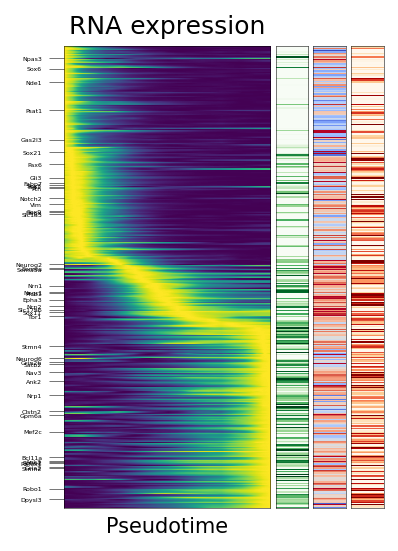

In [123]:
argsort = np.argsort(np.argmax(exp_df_mmscale, axis=1))

X = np.arange(exp_df_mmscale.shape[0])
y0 = np.log10(gene_class.set_index('Gene').loc[exp_df_mmscale.index,'gene_length'][argsort])
y1 = gene_class.set_index('Gene').loc[exp_df_mmscale.index,'MeCP2_Dam126_all'][argsort]
y2 = gene_class.set_index('Gene').loc[exp_df_mmscale.index,'5hmC_neurons'][argsort]

f, ax = plt.subplots(1, 4, figsize=(2.75,4), gridspec_kw={'width_ratios':[.8,.125,.125,.125],'wspace':.075})

ax[0].imshow(exp_df_mmscale.iloc[argsort], 
          aspect='auto', 
          vmin=0, 
          vmax=1,
)

ax[1].pcolorfast(y0.values.reshape(-1,1), 
                 vmin=np.log10(50_000), 
                 vmax=np.log10(1_000_000),
                 cmap='Greens'
)
ax[2].pcolorfast(y1.values.reshape(-1,1), 
                 vmin=.6, 
                 vmax=1.5,
                 cmap='coolwarm'
)

ax[3].pcolorfast(y2.values.reshape(-1,1), 
                 vmin=.1,
                 vmax=.6,
                 cmap='OrRd'
)

for i in (1,2,3):
    ax[i].invert_yaxis()
    ax[i].set_xticks([])
    ax[i].set_yticks([])

ax[1].margins(y=0)
ax[0].set_title('RNA expression')
ax[0].set_xticks([])
ax[0].set_xlabel('Pseudotime')

yticks = [_d[var] + .5 for var in plot_var_names]
ax[0].set_yticks(yticks)
_ = ax[0].set_yticklabels(plot_var_names, fontsize=3)

_____

In [124]:
lad_activating_var_ids = gene_class.loc[(gene_class['class'] == 'LAD') & 
                                        (gene_class['trend'] == 'activating'),'Accession']
lad_deactivating_var_ids = gene_class.loc[(gene_class['class'] == 'LAD') & 
                                          (gene_class['trend'] == 'deactivating'),'Accession']

lad_activating_var_ids.size, lad_deactivating_var_ids.size

(183, 181)

Text(0.5, 1.0, 'dyn-LAD genes')

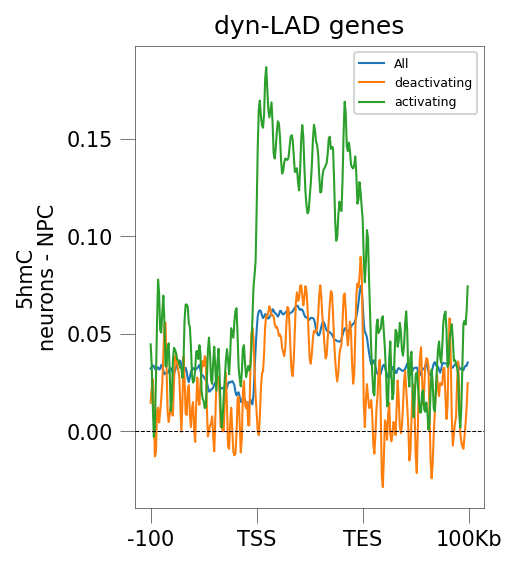

In [127]:
window = 100_000

f, ax = plt.subplots(figsize=(3,4), dpi=150)

labels = ['All','deactivating','activating']
for i,gene_ids in enumerate([deseq_mecp2.index,lad_deactivating_var_ids,lad_activating_var_ids]):
    regions = gtf.loc[gene_ids,['Chromosome','Start','End']].values
    strand = gtf.loc[gene_ids,'Strand'].values
    
    a2d_npc, bounds = scct.scale_regions(regions, h5mc_1kb['npc'], 1_000, window, strand=strand)
    a2d_npc = gaussian_filter(a2d_npc[bounds], 1)

    a2d_neurons, bounds = scct.scale_regions(regions, h5mc_1kb['neurons'], 1_000, window, strand=strand)
    a2d_neurons = gaussian_filter(a2d_neurons[bounds], 1)
    
    a2d_diff = a2d_neurons - a2d_npc
    
    
    ax.plot(a2d_diff.mean(0), color=COLORS[i], lw=1, label=f"{labels[i]}")
    
ax.legend(prop={'size':6}, bbox_to_anchor=(1,1))

#ax.set_ylabel(f"OE({sample})")
ax.set_xticks([0,100,200,300])
ax.set_xticklabels([-100,'TSS','TES','100Kb'])

ax.set_ylabel('5hmC\nneurons - NPC')
ax.axhline(0, lw=.5, ls='--', color='k')

ax.set_title('dyn-LAD genes')

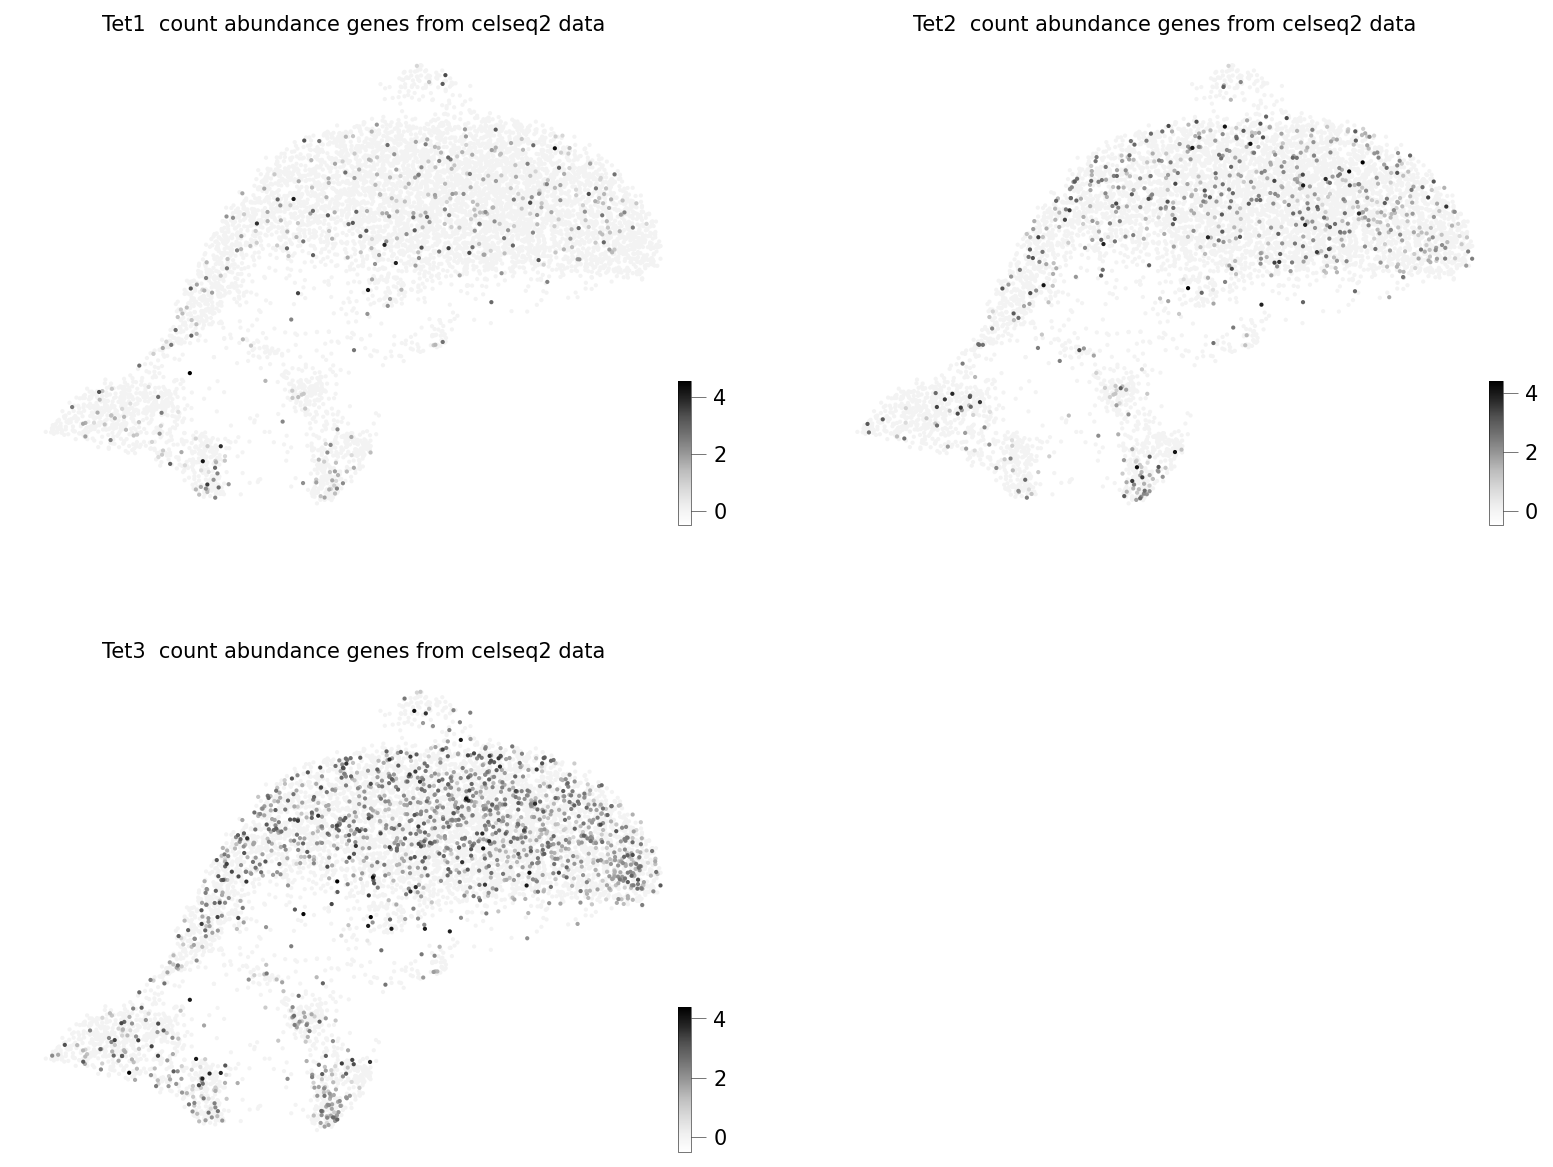

In [128]:
var_names = ['Tet1','Tet2','Tet3']

scv.pl.scatter(adata, 
               basis='umap_ref', 
               color=var_names, 
               layer='count_abundance_genes_from_celseq2_data',
               cmap='Greys',
               vmin=-.5,
               ncols=2,
)

______

Text(0.5, 1.0, 'E15.5 microarray')

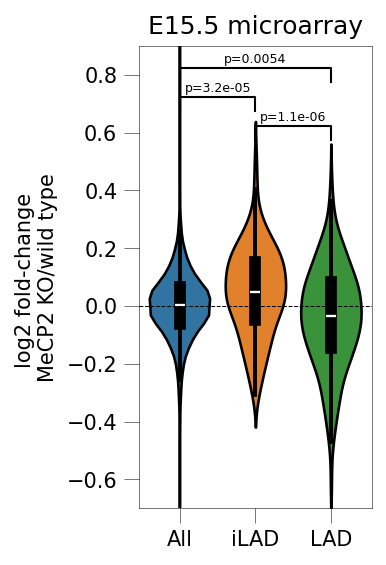

In [130]:
idx = np.isin(gene_class['Gene'], microarray.index)

X = gene_class.loc[idx,'class'].values
y = microarray.loc[gene_class.loc[idx,'Gene'].values,'l2fc'].values

X = np.r_[np.repeat('All',microarray.shape[0]),
          gene_class.loc[idx,'class'].values,
]
y = np.r_[microarray['l2fc'].values,
          microarray.loc[gene_class.loc[idx,'Gene'].values,'l2fc'].values,
]

f, ax = plt.subplots(figsize=(2,4))

sns.violinplot(x=X, 
            y=y, 
            palette=list(COLORS[:3]),  
               edgecolor='k'
)

ymin, ymax = -.7, .9
ax.set_ylim(ymin,ymax)

#ttest All vs iLAD
p = stats.ttest_ind(y[X=='All'],y[X=='iLAD'], equal_var=False)[1]

#annotate
x1, x2 = 0, 1
y0, h = ymax - .225, .05
ax.plot([x1, x1, x2, x2], [y0, y0+h, y0+h, y0], lw=1, c='k')
ax.text((x1+x2)*.5, y0+h+.007, f"p={p:.2}", ha='center', va='bottom', c='k', fontsize=6)

#ttest iLAD vs LAD
p = stats.ttest_ind(y[X=='iLAD'],y[X=='LAD'], equal_var=False)[1]

#annotate
x1, x2 = 1, 2
y0, h = ymax - .325, .05
ax.plot([x1, x1, x2, x2], [y0, y0+h, y0+h, y0], lw=1, c='k')
ax.text((x1+x2)*.5, y0+h+.007, f"p={p:.2}", ha='center', va='bottom', c='k', fontsize=6)

#ttest All vs LAD
p = stats.ttest_ind(y[X=='All'],y[X=='LAD'], equal_var=False)[1]

#annotate
x1, x2 = 0, 2
y0, h = ymax - .125, .05
ax.plot([x1, x1, x2, x2], [y0, y0+h, y0+h, y0], lw=1, c='k')
ax.text((x1+x2)*.5, y0+h+.007, f"p={p:.2}", ha='center', va='bottom', c='k', fontsize=6)

ax.set_ylabel('log2 fold-change \nMeCP2 KO/wild type')

ax.axhline(0, lw=.5, ls='--', color='k', zorder=10)

ax.set_title('E15.5 microarray')

In [131]:
microarray_sub = microarray[microarray.index.isin(gtf['gene_name'])].copy()

d = dict(zip(gtf['gene_name'],gtf.index))
microarray_sub['gene_id'] = [d[g] for g in microarray_sub.index]

d = dict(zip(gtf['gene_name'],gtf['gene_length']))
microarray_sub['gene_length'] = [d[g] for g in microarray_sub.index]

microarray_sub = microarray_sub[(microarray_sub['gene_length'] >= 1_000) & 
                                (microarray_sub['gene_length'] < 1_000_000)
].copy()

microarray_sub.shape

(5927, 6)

Text(0.1, 0.2, 'p = 4.25e-61')

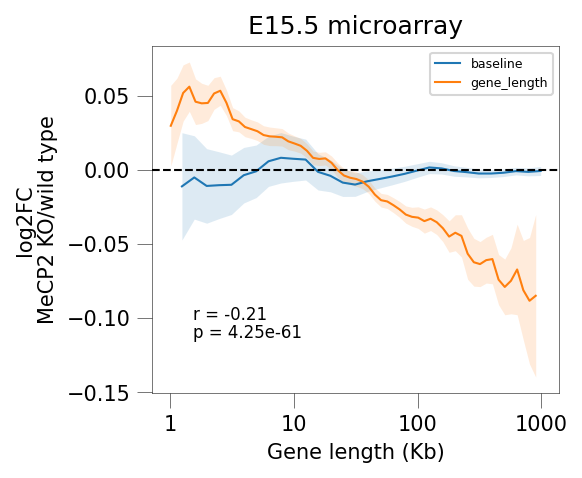

In [132]:
X = np.log10(microarray_sub['gene_length'])
y = microarray_sub['l2fc']

np.random.seed(1)
X_rand = np.log10(np.random.randint(1_000,1_000_000,y.size))

xhat_baseline, yhat_baseline, yhat_sem_baseline = sccu.RNR(X=X_rand, 
                                y=y, 
                                _RADIUS=.2, 
                                step=.1
)

xhat, yhat, yhat_sem = sccu.RNR(X=X, 
                                y=y, 
                                _RADIUS=.08, 
                                step=.05
)

f, ax = plt.subplots(figsize=(3.5,3))

ax.plot(xhat_baseline, 
        yhat_baseline, 
        color=COLORS[0], 
        label='baseline',
        lw=1,
)
ax.fill_between(xhat_baseline, 
                yhat_baseline - yhat_sem_baseline, 
                yhat_baseline + yhat_sem_baseline, 
                color=COLORS[0], 
                alpha=.15,
                lw=0
)

ax.plot(xhat, 
        yhat, 
        color=COLORS[1],
        label=X.name,
        lw=1
)
ax.fill_between(xhat, 
                yhat - yhat_sem, 
                yhat + yhat_sem, 
                color=COLORS[1],
                alpha=.15,
                lw=0
)

ax.axhline(0, lw=1, ls='--', color='k')

ax.legend(prop={'size':6})
ax.set_ylabel('log2FC\nMeCP2 KO/wild type')
ax.set_xticks(range(3,7))
ax.set_xticklabels(10**np.arange(3,7) // 1_000)

ax.set_xlabel('Gene length (Kb)')
ax.set_title('E15.5 microarray')

rho, p = stats.pearsonr(X, y)
ax.text(0.1, 0.25, f'r = {rho:.2f}', transform=ax.transAxes, 
        fontsize=8, verticalalignment='top', horizontalalignment='left')
ax.text(0.1, 0.20, f'p = {p:.3}', transform=ax.transAxes, 
        fontsize=8, verticalalignment='top', horizontalalignment='left')